# New York City Parking Ticket Analysis
## Query Questions Draft
### 1. Distribution of parking tickets issued over the year.
### 2. PAS VS. COM 
### 3. States
### 4. Vehicle Body Type
### 5. Vehicle Make
### 6. Street Code

In [60]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mp 
%matplotlib inline

In [61]:
raw_data_1415 = pd.read_csv("Parking_Violations_Issued_-_Fiscal_Year_2015.csv") 

In [212]:
raw_data_1415.head(10)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Hydrant Violation,Double Parking Violation,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,8002531292,EPC5238,NY,PAS,10/01/2014,21,SUBN,CHEVR,T,20390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8015318440,5298MD,NY,COM,03/06/2015,14,VAN,FRUEH,T,27790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7611181981,FYW2775,NY,PAS,07/28/2014,46,SUBN,SUBAR,T,8130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7445908067,GWE1987,NY,PAS,04/13/2015,19,4DSD,LEXUS,T,59990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7037692864,T671196C,NY,PAS,05/19/2015,19,4DSD,CHRYS,T,36090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7704791394,JJF6834,PA,PAS,11/20/2014,21,4DSD,NISSA,T,74230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7541599104,FYP8263,NY,PAS,08/01/2014,21,SUBN,HONDA,T,77530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7443513951,FZL7450,NY,PAS,07/19/2014,71,4DSD,VOLVO,T,49210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,7426321423,86318MA,NY,COM,09/23/2014,69,VAN,CHEVR,T,21690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,8017159560,GKX8095,NY,PAS,01/20/2015,71,4DSD,LEXUS,T,35490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1. Distribution of parking tickets issued over the year.

In [328]:
# Select the Columns with 'Issue Date' and 'Summons Number'
IssueDate_SNum_1415 = raw_data_1415[['Issue Date','Summons Number']]

In [329]:
# Fill any N/A with number 0
IssueDate_SNum_1415 = IssueDate_SNum_1415.fillna(0) 

In [330]:
IssueDate_SNum_1415.head()

,Issue Date,Summons Number
0,10/01/2014,8002531292
1,03/06/2015,8015318440
2,07/28/2014,7611181981
3,04/13/2015,7445908067
4,05/19/2015,7037692864


In [331]:
# group the data by dates and count the total number of P
IssueDate_SNum_1415 = IssueDate_SNum_1415.groupby('Issue Date', as_index = False).count()

In [332]:
IssueDate_SNum_1415['Issue Date'] = pd.to_datetime(IssueDate_SNum_1415['Issue Date'])

In [333]:
IssueDate_SNum_1415 = IssueDate_SNum_1415.set_index('Issue Date')

In [337]:
IssueDate_SNum_1415 = IssueDate_SNum_1415.loc['2014-07-01':'2015-07-01']

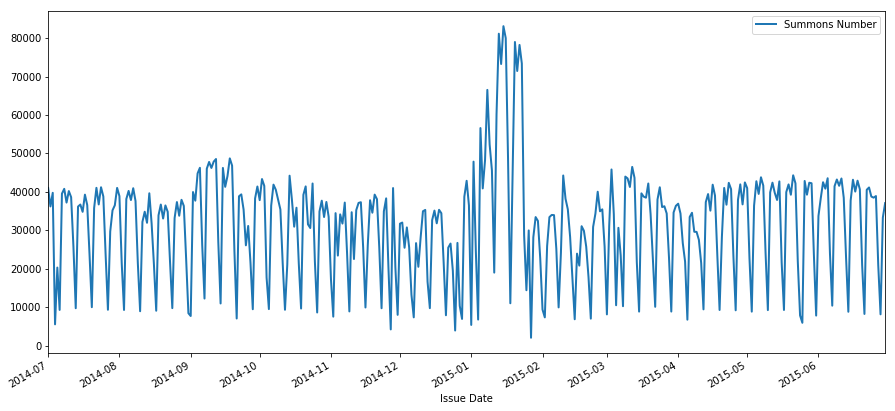

In [343]:
IssueDate_SNum_1415.plot(figsize = [15,7], linewidth=2)